Import libraries

In [1]:
from Perturbation import *
from Sequential_feature_selection import *
from Cross_validation.KFold import *
from Cross_validation.TimeSeriesSplit import *
from sklearn.datasets import *
from Plots.Prediction_plots import *
from Cross_validation.TimeSeriesData import *
Plots = Prediction_plots()
converter = Covert_to_Time_Series()

Create train and test sets

In [2]:
zbior = load_breast_cancer()
data = pd.DataFrame(zbior.data, columns= zbior.feature_names)
data['target'] = pd.Series(zbior.target)
X = data.drop('target', axis=1).values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

Perturabtion

Feature ranking: [18 28 13 27 26 25 24  4 23 22  9 10 21  5 30 19 29 12 14  6 16  7  3  1
  8 15 17  2 20 11]


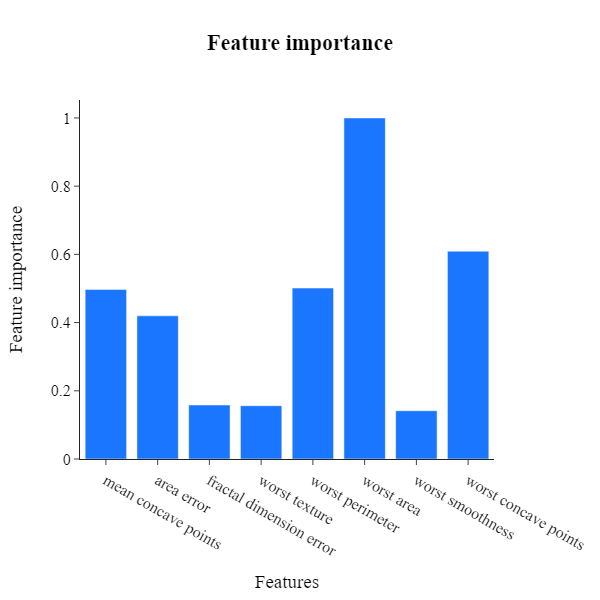

In [3]:
model = DecisionTreeClassifier(random_state=17)
perturbacja = Perturabtion(algorithm=model, metric="roc_auc", n_repeats=10)
perturbacja.fit(X_train, y_train)
print("Feature ranking: {}".format(perturbacja.ranking_))
Plots.plot_feature_importances(feature_importances=perturbacja.feature_importances_, column_names=list(data.drop("target", axis=1).columns), nlargest=8)

We can also check how our feature importance plot looks like without scaling the data. So in other words how muuch our roc_auc score decrease after perturbating selected feature.

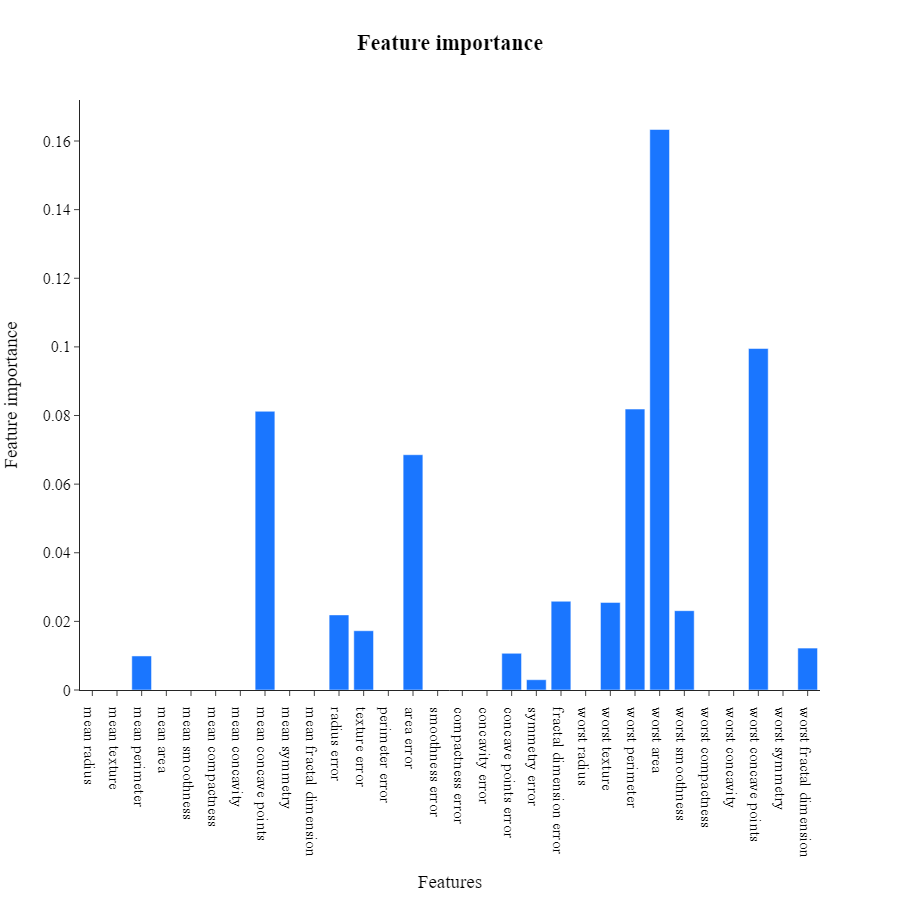

In [4]:
Plots.plot_feature_importances(feature_importances=perturbacja.unscaled_feature_importances_, column_names=list(data.drop("target", axis=1).columns))

To verify that our perturbation technique works, we will create additional dataset with 10 features. 

In this dataset our target is dependent from variable at index 3 and 8, because in:

- classification:  x3*x8<median(x3*x8) => 1 else 0.

- regression: y = 0.5*x3+0.5*x8

Therefore our plot should simply return that features 3 and 8 are the most important.

In [5]:
def create_data(problem_type):
    x = np.random.uniform(0, 100, size=(500, 10))
    if(problem_type=="classification"):
        return x, np.where(x[:,3]*x[:,8] < np.quantile(x[:,0]*x[:,1], q=0.5), 1, 0)
    else:
        return x, 0.5*x[:, 3]+0.5*x[:, 8]
X, y = create_data("classification")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

Feature ranking: [ 7  4  5  2  8  6  3  9  1 10]


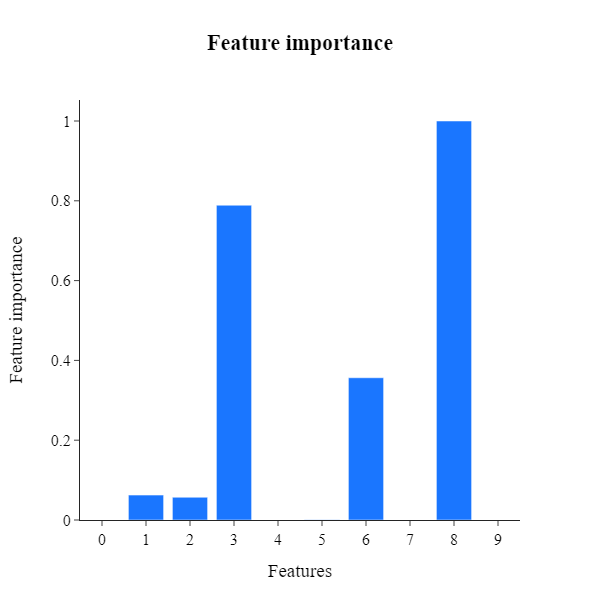

In [6]:
model = DecisionTreeClassifier(random_state=17)
perturbacja = Perturabtion(algorithm=model, metric="roc_auc", n_repeats=10)
perturbacja.fit(X_train, y_train)
print("Feature ranking: {}".format(perturbacja.ranking_))
Plots.plot_feature_importances(feature_importances=perturbacja.feature_importances_)

As we can see from above chart our Perturbation method works fine

Now let's check regression

Feature ranking: [10  3  4  2  9  8  6  7  1  5]


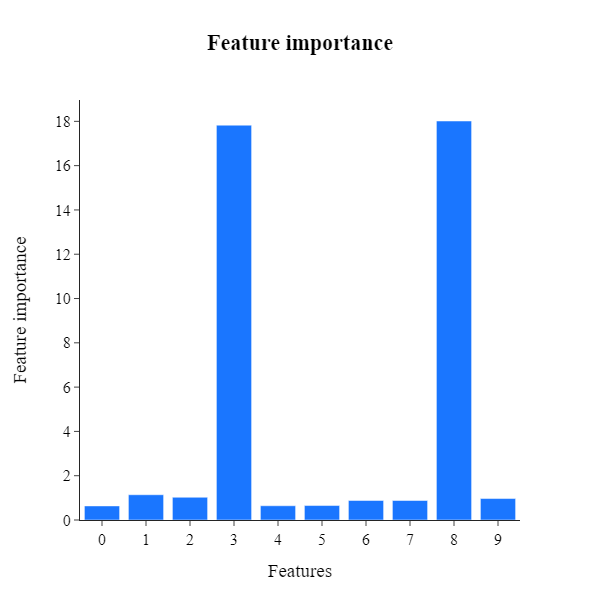

In [7]:
X, y = create_data("regression")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)
model = DecisionTreeRegressor(random_state=17)
perturbacja = Perturabtion(algorithm=model, metric="neg_rmse", n_repeats=10)
perturbacja.fit(X_train, y_train)
print("Feature ranking: {}".format(perturbacja.ranking_))
Plots.plot_feature_importances(feature_importances=perturbacja.unscaled_feature_importances_)

I also made Perturbation class compatible with pytorch LSTM

In [8]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, problem_type):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.problem_type = problem_type
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def predict(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        #hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        hn = hn[-1,:,:].view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        if(self.problem_type=="classification"):
           out = torch.sigmoid(out)
        return out

class LSTM_model():
  def __init__(self, problem_type, random_state=17, metric="mse"):
    self.problem_type = problem_type
    self.random_state = random_state
    random.seed(random_state)
    metrics = {"binary_crossentropy": nn.BCELoss(),
                     "crossentropy": nn.CrossEntropyLoss(),
                     "hinge": nn.HingeEmbeddingLoss(),
                     "mse": torch.nn.MSELoss(),
                     "rmse": RMSELoss(),
                     "mae": torch.nn.L1Loss(),
                     "neg_mse": torch.nn.MSELoss(),
                     "neg_rmse": RMSELoss(),
                     "neg_mae": torch.nn.L1Loss()}
    if metric not in metrics:
        raise ValueError('Unsupported metric: {}'.format(metric))
    self.metric = metric
    self.eval_metric = metrics[metric]
    self.metric_type = metrics[metric]
 
  def fit(self, X, y, epochs=200, learning_rate=0.01, X_valid=None, y_valid=None, verbose=True):
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.verbose = verbose
    if(X_valid != None and y_valid != None):
      self.X_train = X
      self.y_train = y
      self.X_valid = X_valid
      self.y_valid = y_valid
    else:
      self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=0.2, random_state=self.random_state)
    self.model = LSTM(num_classes=self.y_train.shape[1], input_size = self.X_train.shape[2], hidden_size=16, num_layers=1, problem_type=self.problem_type) 
    self.load_best_valid_model_ = LSTM(num_classes=self.y_train.shape[1], input_size = self.X_train.shape[2], hidden_size=16, num_layers=1, problem_type=self.problem_type) 
    loss_fn = self.eval_metric
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    self.train_losses = []
    self.valid_losses = []
    best_valid_loss = np.inf
    for epoch in range(self.epochs):
      self.model.train()
      outputs = self.model.predict(self.X_train)
      optimizer.zero_grad()
      train_loss = loss_fn(outputs, self.y_train)
      self.train_losses.append(train_loss.item())
      train_loss.backward()
      optimizer.step()
      with torch.no_grad():
        self.model.eval()
        valid_preds = self.model.predict(self.X_valid)
        valid_loss = loss_fn(valid_preds, self.y_valid)
        self.valid_losses.append(valid_loss.item())
        if(valid_loss < best_valid_loss):
          best_valid_loss = valid_loss
          torch.save(self.model.state_dict(), 'saved_models/temp_best_model.pth')
          self.load_best_valid_model_.load_state_dict(torch.load('saved_models/temp_best_model.pth'))
      if(epoch%10 == 0 and self.verbose == True):
        print("EPOCH: {}: Train loss: {}; Valid loss: {}; Current best valid loss: {}".format(epoch, train_loss, valid_loss, best_valid_loss))

  def predict(self, X):
    if(self.problem_type == "classification"):
      return (self.model.predict(X) > 0.5).float().detach().squeeze(1)
    else:
       return self.model.predict(X).detach().squeeze(1)
    
  def predict_proba(self, X):
     return torch.cat((1-self.model.predict(X), self.model.predict(X)), dim=1).detach().squeeze(1)

EPOCH: 0: Train loss: 3126.227294921875; Valid loss: 2607.435791015625; Current best valid loss: 2607.435791015625
EPOCH: 10: Train loss: 2307.746337890625; Valid loss: 1775.0718994140625; Current best valid loss: 1775.0718994140625
EPOCH: 20: Train loss: 563.2831420898438; Valid loss: 508.0240173339844; Current best valid loss: 508.0240173339844
EPOCH: 30: Train loss: 583.2722778320312; Valid loss: 868.541015625; Current best valid loss: 508.0240173339844
EPOCH: 40: Train loss: 403.4737243652344; Valid loss: 509.94122314453125; Current best valid loss: 508.0240173339844
EPOCH: 50: Train loss: 409.712646484375; Valid loss: 515.4981689453125; Current best valid loss: 505.6787109375
EPOCH: 60: Train loss: 402.1666564941406; Valid loss: 586.244140625; Current best valid loss: 505.6787109375
EPOCH: 70: Train loss: 394.7742614746094; Valid loss: 535.7743530273438; Current best valid loss: 505.6787109375
EPOCH: 80: Train loss: 395.1536560058594; Valid loss: 538.1109619140625; Current best va

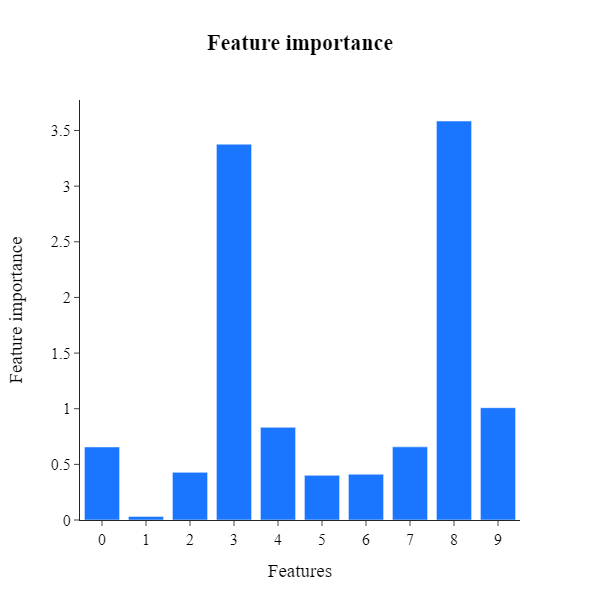

In [9]:
lstm = LSTM_model(problem_type="regression", random_state=17, metric="mse")
X_lstm, y_lstm = converter.create_lstm_data_torch(X_train, y_train, seq_length=3)
y_lstm = y_lstm.reshape(-1, 1)
perturbacja = Perturabtion(algorithm=lstm, metric="neg_rmse", n_repeats=10)
perturbacja.fit(X_lstm, y_lstm)
print("Feature ranking: {}".format(perturbacja.ranking_))
Plots.plot_feature_importances(feature_importances=perturbacja.unscaled_feature_importances_)

Forward Feature Selection

In [10]:
sfs = Sequential_feature_selection(algorithm=DecisionTreeRegressor(random_state=17), metric="neg_mse", cv=KFold(n_splits=5, shuffle=True, stratify=True))
sfs.forward_fit(X_train, y_train)
print("List of best features indexes: {}".format(sfs.list_of_best_variables_indexes))
print("Check support: {}".format(sfs.support_))
#Transform our train and test set that it will only contains selected features
print("Before change X_train shape: {}".format(X_train.shape))
X_train_transformed = sfs.transform(X_train)
X_test_transformed = sfs.transform(X_test)
print("After change X_train shape: {}".format(X_train_transformed.shape))

List of best features indexes: [8, 0, 3, 7]
Check support: [ True False False  True False False False  True  True False]
Before change X_train shape: (400, 10)
After change X_train shape: (400, 4)


It will work also for LSTM and classification dataset

In [11]:
X, y = create_data("classification")
X_lstm, y_lstm = converter.create_lstm_data_torch(X, y, seq_length=7)
y_lstm = y_lstm.reshape(-1, 1)
lstm = LSTM_model(problem_type="classification", random_state=17, metric="binary_crossentropy")
sfs = Sequential_feature_selection(algorithm=lstm, metric="roc_auc", cv=Time_Series(n_splits=3))
sfs.forward_fit_lstm(X_lstm, y_lstm)
print("List of best features indexes: {}".format(sfs.list_of_best_variables_indexes))
print("Check support: {}".format(sfs.support_))
#Transform our train and test set that it will only contains selected features
print("Before change X_train shape: {}".format(X_train.shape))
X_train_transformed = sfs.transform(X_train)
X_test_transformed = sfs.transform(X_test)
print("After change X_train shape: {}".format(X_train_transformed.shape))

EPOCH: 0: Train loss: 0.6890766620635986; Valid loss: 0.8021191954612732; Current best valid loss: 0.8021191954612732
EPOCH: 10: Train loss: 0.6785736680030823; Valid loss: 0.7726941108703613; Current best valid loss: 0.7264935970306396
EPOCH: 20: Train loss: 0.6583852767944336; Valid loss: 0.7770689129829407; Current best valid loss: 0.7264935970306396
EPOCH: 30: Train loss: 0.634577214717865; Valid loss: 0.8397402763366699; Current best valid loss: 0.7264935970306396
EPOCH: 40: Train loss: 0.6044880747795105; Valid loss: 0.9521329402923584; Current best valid loss: 0.7264935970306396
EPOCH: 50: Train loss: 0.5643956661224365; Valid loss: 1.019618272781372; Current best valid loss: 0.7264935970306396
EPOCH: 60: Train loss: 0.49092406034469604; Valid loss: 1.0842593908309937; Current best valid loss: 0.7264935970306396
EPOCH: 70: Train loss: 0.45153024792671204; Valid loss: 1.3191196918487549; Current best valid loss: 0.7264935970306396
EPOCH: 80: Train loss: 0.4331369698047638; Valid 

Backward Feature selection

In [12]:
X, y = create_data("classification")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)
sfs = Sequential_feature_selection(algorithm=DecisionTreeClassifier(random_state=17), metric="accuracy")
sfs.backward_fit(X_train, y_train)
print("List of best features indexes: {}".format(sfs.list_of_best_variables_indexes))
print("Check support: {}".format(sfs.support_))
#Transform our train and test set that it will only contains selected features
print("Before change X_train shape: {}".format(X_train.shape))
X_train_transformed = sfs.transform(X_train)
X_test_transformed = sfs.transform(X_test)
print("After change X_train shape: {}".format(X_train_transformed.shape))

List of best features indexes: [3 7 8 9]
Check support: [False, False, False, True, False, False, False, True, True, True]
Before change X_train shape: (400, 10)
After change X_train shape: (400, 4)
